# Volume-weighted T/S Diagram from WOA

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.77:36879")
client

Client Scheduler: tcp://10.32.16.77:36879 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 15 Cores: 30 Memory: 172.50 GB


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr
import gsw

In [6]:
xr.set_options(display_style='text')

In [3]:
from xhistogram.xarray import histogram
from matplotlib.colors import LogNorm

In [7]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
lower_lat = -79.5
upper_lat = -61.5
left_lon = -64.5
right_lon = 30.5

In [8]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

In [9]:
temp = ds.tan.sel(**lat_range, **lon_range)
salt = ds.san.sel(**lat_range, **lon_range)

In [10]:
land_mask = ds.tan.isnull()

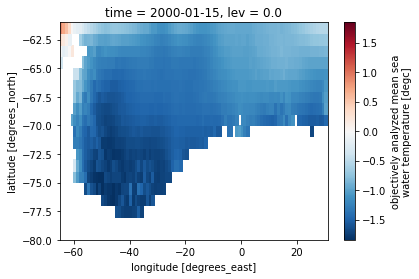

In [11]:
temp[0,0].where(~land_mask[0,0]).plot() #~ reverses the logic 

In [12]:
# Create a dz variable
dz = np.diff(ds.lev)
dz = np.insert(dz, 0, dz[0]) #inserts 1st value of original dz into the first index to make it same size as ds.lev
dz = xr.DataArray(dz, coords= {'lev':ds.lev}, dims='lev')

In [13]:
dlat = np.diff(ds.lat)[0]

# check that spacing is uniform
np.testing.assert_allclose(np.diff(ds.lat), dlat)
dlon = np.diff(ds.lon)[0]
np.testing.assert_allclose(np.diff(ds.lon), dlon)
(dlon, dlat)

(1.0, 1.0)

In [14]:
rad_earth = 6378.1e3 #meters

#create a dy variable
dy = rad_earth * np.deg2rad(dlat)
dy

111318.84502145034

In [15]:
#create a dx variable
dx = rad_earth * np.deg2rad(dlon) * np.cos(np.deg2rad(ds.lat))

In [16]:
area, _, _ = xr.broadcast(dx * dy, ds.lat, ds.lon)
area

<xarray.DataArray 'lat' (lat: 180, lon: 360)>
array([[1.08138227e+08, 1.08138227e+08, 1.08138227e+08, ...,
        1.08138227e+08, 1.08138227e+08, 1.08138227e+08],
       [3.24381740e+08, 3.24381740e+08, 3.24381740e+08, ...,
        3.24381740e+08, 3.24381740e+08, 3.24381740e+08],
       [5.40526443e+08, 5.40526443e+08, 5.40526443e+08, ...,
        5.40526443e+08, 5.40526443e+08, 5.40526443e+08],
       ...,
       [5.40526443e+08, 5.40526443e+08, 5.40526443e+08, ...,
        5.40526443e+08, 5.40526443e+08, 5.40526443e+08],
       [3.24381740e+08, 3.24381740e+08, 3.24381740e+08, ...,
        3.24381740e+08, 3.24381740e+08, 3.24381740e+08],
       [1.08138227e+08, 1.08138227e+08, 1.08138227e+08, ...,
        1.08138227e+08, 1.08138227e+08, 1.08138227e+08]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [17]:
dV = area * dz
dV_wg = dV.sel(**lat_range, **lon_range).where(~land_mask[0])

In [18]:
dV_wg.sum()

<xarray.DataArray ()>
array(1.95668641e+16)
Coordinates:
    time     datetime64[ns] 2000-01-15

In [19]:
#salt_bins = np.linspace(33, 35, 100)
#theta_bins = np.linspace(-2.2, 4.2, 100)

salt_bins = np.linspace(31, 35, 100) #to match model bins
theta_bins = np.linspace(-2.5, 8, 100) #to match model bins

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

In [20]:
# open an issue on xhistogram that describes this error when not using [0]
# xhistogram should be able to deal with it fine
# (use synthetic example, not real data)
ts_hist_8110 = histogram(temp[0].rename('theta'), salt[0].rename('salt'), 
                    bins=[theta_bins, salt_bins], 
                    weights=dV_wg,
                    dim=['lon', 'lat', 'lev']) / (delta_salt * delta_theta)

In [21]:
ts_hist_8110

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [24]:
ts_hist_8110 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_8110.nc')

In [25]:
ts_hist_8110

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


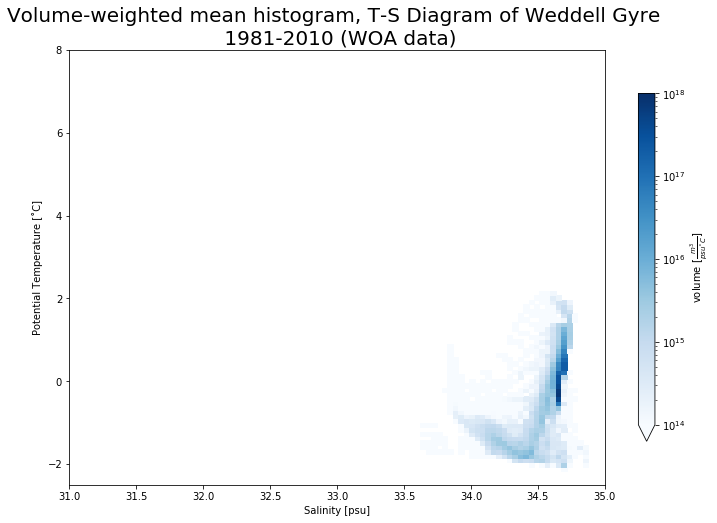

In [26]:
ts_hist_8110.where(ts_hist_8110>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                              vmin=1e14, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1981-2010 (WOA data)', fontsize=20);

## <span style='color:Brown'> Converting __psu__ to __Absolute Salinity__ and __in situ__ temperature to __potential__ temperature

### read from Ryan

In [27]:
from fastjmd95 import jmd95numba

In [28]:
tan = ds.tan.sel(**lat_range, **lon_range).load()
san = ds.san.sel(**lat_range, **lon_range).load()

In [29]:
lat = ds.lat.sel(**lat_range)
lon = ds.lon.sel(**lon_range)

In [30]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, tan.lev, lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [31]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, san, pressure, lon, lat,
                    output_dtypes=[san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [32]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, tan, pressure,
                    output_dtypes=[tan.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

In [33]:
#salt_bins = np.linspace(33, 35, 100)
#theta_bins = np.linspace(-2.2, 4.2, 100)

salt_bins = np.linspace(31, 35, 100) #to match model bins
theta_bins = np.linspace(-2.5, 8, 100) #to match model bins

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

In [37]:
# open an issue on xhistogram that describes this error when not using [0]
# xhistogram should be able to deal with it fine
# (use synthetic example, not real data)
ptsa_hist_8110 = histogram(pt[0], sa[0], bins=[theta_bins, salt_bins], weights=dV_wg,
                         dim=['lon', 'lat', 'lev']).rename({'PT_bin':'theta_bin',
                                                            'SA_bin':'salt_bin'}) / (delta_salt * delta_theta)

In [38]:
ptsa_hist_8110

<xarray.DataArray 'histogram_PT_SA' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


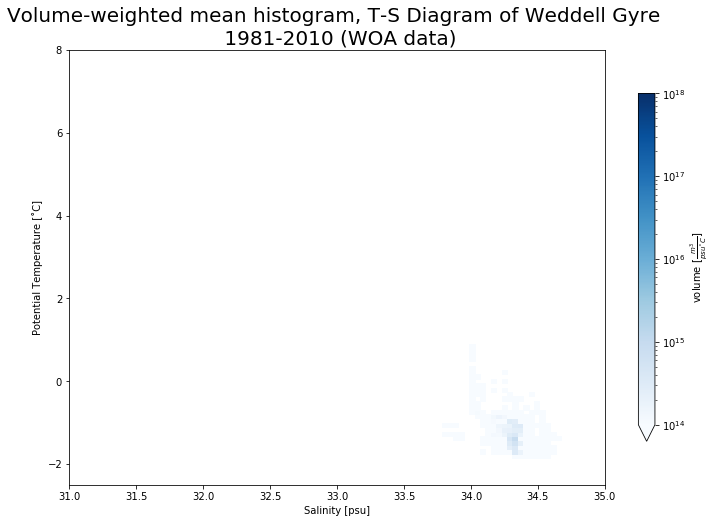

In [39]:
ptsa_hist_8110.where(ptsa_hist_8110>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                     cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                     vmin=1e14, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1981-2010 (WOA data)', fontsize=20);

In [40]:
sigma2 = jmd95numba.rho(ts_hist_8110.salt_bin, ts_hist_8110.theta_bin, 2000.)

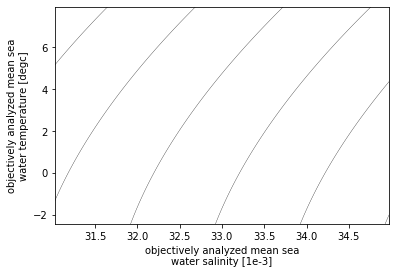

In [41]:
sigma2.transpose().plot.contour(colors='k', linewidths=0.3);

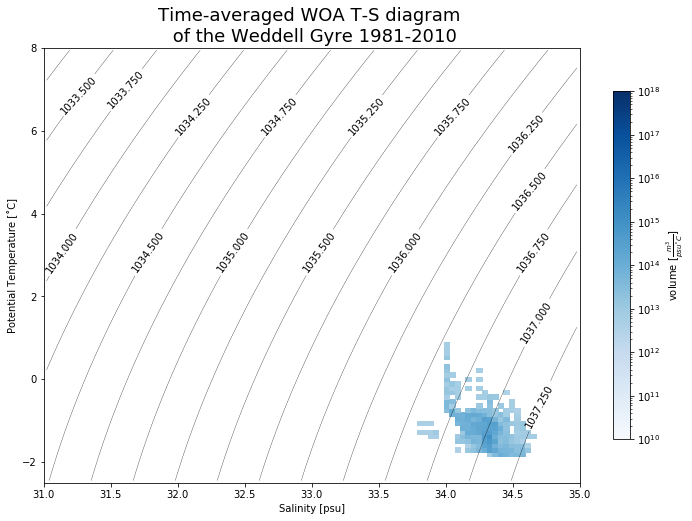

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)

ptsa_hist_8110.where(ptsa_hist_8110>0).plot(norm=LogNorm(), cmap='Blues',
                     cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                     vmin=1e10, vmax=1e18)

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Time-averaged WOA T-S diagram \n of the Weddell Gyre 1981-2010', fontsize=18);

* You can take the difference between the scatter plots (ex: SOSE-WOA) and compare does the model have enough points
* this is a naive way - there is no weights involved, you have to figure that out yourself for WOA data - refer back to notes in Slack by Ryan and maybe xgcm package by Julius

## 2005 - 2017

In [51]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [52]:
temp_0517 = ds_0517.tan.sel(**lat_range, **lon_range)
salt_0517 = ds_0517.san.sel(**lat_range, **lon_range)

In [54]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, temp_0517.lev, lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [56]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, salt_0517, pressure, lon, lat,
                    output_dtypes=[salt_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [57]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, temp_0517, pressure,
                    output_dtypes=[temp_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

In [58]:
ts_hist_0517 = histogram(temp_0517[0].rename('theta'), salt_0517[0].rename('salt'), 
                         bins=[theta_bins, salt_bins],
                         weights=dV_wg,
                         dim=['lon', 'lat', 'lev']) / (delta_salt * delta_theta)

In [59]:
ts_hist_0517

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [61]:
ts_hist_0517 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_0517.nc')

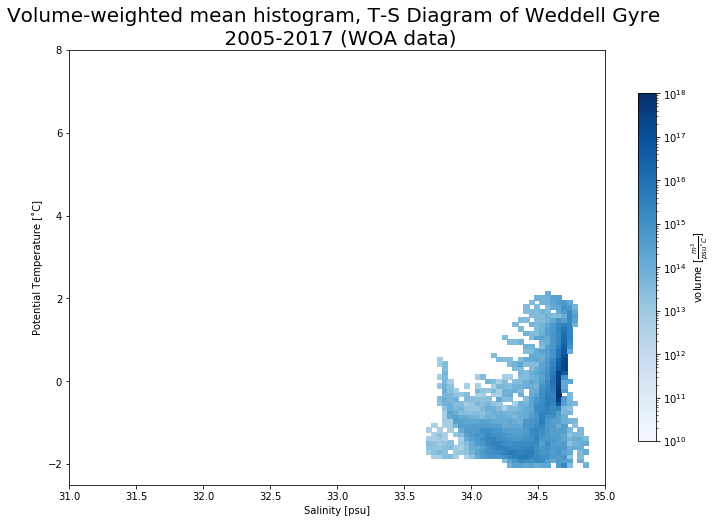

In [63]:
ts_hist_0517.where(ts_hist_0517>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                                        vmin=1e10, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2017 (WOA data)', fontsize=20);

In [64]:
sigma2_0517 = jmd95numba.rho(ts_hist_0517.salt_bin, ts_hist_0517.theta_bin, 2000.)

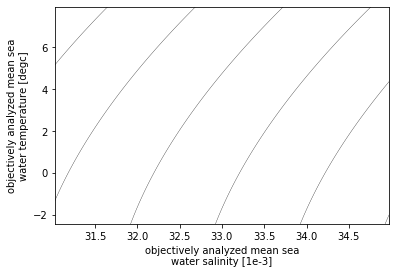

In [65]:
sigma2.transpose().plot.contour(colors='k', linewidths=0.3);

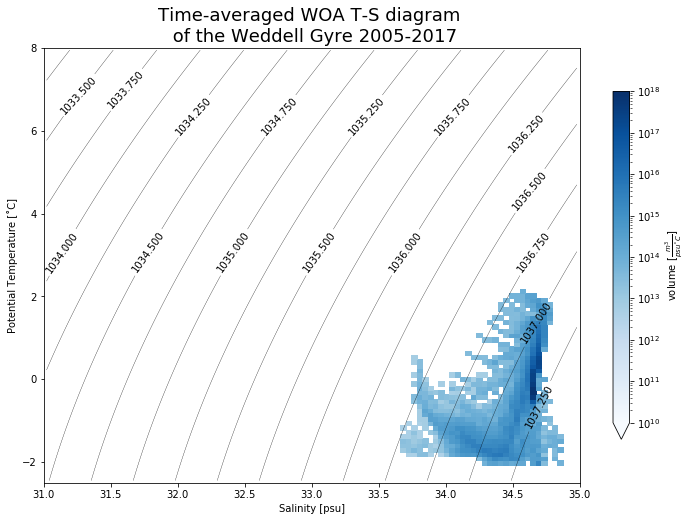

In [68]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)

ts_hist_0517.plot(norm=LogNorm(), cmap='Blues', ax=ax, vmin=1e10, vmax=1e18
                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Time-averaged WOA T-S diagram \n of the Weddell Gyre 2005-2017', fontsize=18);